In [1]:
# Importing python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#Common model helpers
from sklearn.preprocessing import(LabelEncoder)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, accuracy_score,
                             r2_score, mean_squared_error,
                             precision_score,
                             recall_score,
                             f1_score, 
                             confusion_matrix)

# imbalance dataset handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pickle

# model algorithams
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Avoid Warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

results_add = "./modified_results/modified_survey_results_public_"

In [2]:
# reading dataframe containing results from all the surveys 
df_all = pd.read_csv(results_add+"all_years.csv.gz",  compression='gzip')

In [3]:
df_all.head()

,Country,Age_Range,Gender,Salary_Range,Employment_Status,Job_Satisfaction,Formal_Education,UN_subregion,Continent,Year,Company_Size,Career_Satisfaction
0,Croatia,25-29,Male,"$20,000 - $40,000",Employed full-time,Moderately satisfied,Master's degree,Southern Europe,Europe,2015,NaN,NaN
1,France,20-24,Male,"$20,000 - $40,000",Employed full-time,Neither satisfied nor dissatisfied,Master's degree,Western Europe,Europe,2015,NaN,NaN
2,India,20-24,Male,"$80,000 - $100,000",Freelance / Contractor,Moderately satisfied,NaN,Southern Asia,Asia,2015,NaN,NaN
3,Latvia,25-29,Male,NaN,Employed full-time,Moderately satisfied,Bachelor's degree,Northern Europe,Europe,2015,NaN,NaN
4,Norway,30-34,Male,"$60,000 - $80,000",Employed full-time,Extremely satisfied,Bachelor's degree,Northern Europe,Europe,2015,NaN,NaN


## Categorical data relation

In [4]:
#converting categorical columns into numericals
df_temp = df_all[['Gender','Age_Range','Salary_Range','Employment_Status','Formal_Education','Job_Satisfaction']]
df_temp = df_temp.dropna()
labelencoder=LabelEncoder()
df_temp['Gender']=labelencoder.fit_transform(df_temp['Gender'])
df_temp['Age_Range']=labelencoder.fit_transform(df_temp['Age_Range'])
df_temp['Salary_Range']=labelencoder.fit_transform(df_temp['Salary_Range'])
df_temp['Formal_Education']=labelencoder.fit_transform(df_temp['Formal_Education'])
df_temp['Employment_Status']=labelencoder.fit_transform(df_temp['Employment_Status'])
df_temp['Job_Satisfaction']=labelencoder.fit_transform(df_temp['Job_Satisfaction'])

# Encode variables with more than 2 Classes
df_temp = pd.get_dummies(df_temp, columns= [i for i in df_temp.columns if df_temp[i].dtypes=='object'],drop_first=True)

df_temp.head()

,Gender,Age_Range,Salary_Range,Employment_Status,Formal_Education,Job_Satisfaction
0,1,3,15,0,3,3
1,1,1,15,0,3,4
4,1,4,21,0,1,1
7,1,3,21,0,3,3
8,1,4,31,0,1,3


Exploratory analysis and visualisation of relation by heatmap

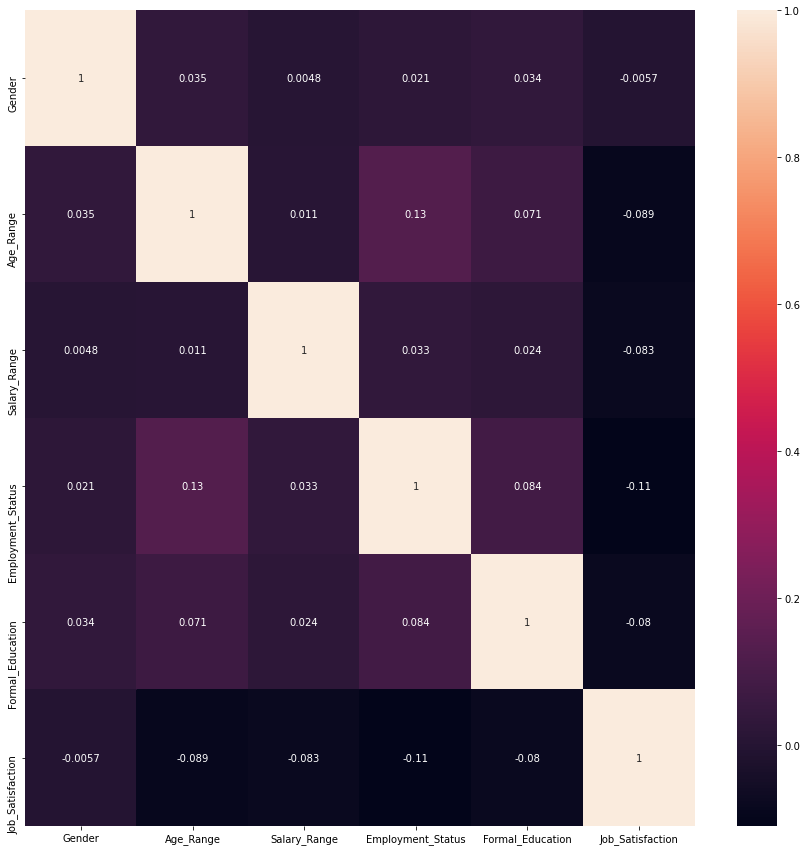

In [5]:
#correlation between columns
plt.figure(figsize=(15,15))
sns.heatmap(df_temp.corr(),annot=True)
plt.savefig('./figures/JS_heatmap.png')

### Train and fit linear model using over and 
Model and data saved after runing these two parts. For avoiding time required for imbalance sampling it's easier to load and use saved data

In [6]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    for col in cat_cols:
        #df = pd.concat([df, pd.get_dummies(df.drop(col,axis=1), prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)],axis=1)
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)

    return df

In [8]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    # 1. Drop the rows with missing response values
    #df = df.dropna(subset=['Salary'], axis=0)
    df  = df.dropna(subset=[response_col], axis=0)
    
    
    # 2. Drop columns with NaN for all the values
    #drop_cols = df.columns[df.isnull().all()==True]
    #df = df.drop(columns = drop_cols)
    df = df.dropna(how ='all' , axis=1)
    
    
    cat_df = df.select_dtypes(include=['object'])
    cat_cols = cat_df.columns
    # 3. Use create_dummy_df to dummy categorical columns
    #cat_df = df.select_dtypes(include=['object'])
    #cat_cols_lst = cat_df.columns
    print(cat_cols)
    df = create_dummy_df(df, cat_cols, dummy_na)
   
    
    # 4. Fill the mean of the column for any missing values
    fill_mean = lambda col: col.fillna(col.mean())
    df = df.apply(fill_mean, axis=0)
    
    # 5. Split your data into an X matrix and a response vector y
    try:
        y = df[response_col]
    except:
        print('Error occured')
    X = df.drop(response_col, axis=1)
    
#     #Scaling X 
#     scaler = MinMaxScaler()
#     X_scale=scaler.fit_transform(X_oversampled)
    
#     ## Balancing Dataset
#     over = SMOTE(sampling_strategy=0.1)
#     under = RandomUnderSampler(sampling_strategy=0.5)
#     steps = [('o', over), ('u', under)]
#     # define pipeline
#     pipeline = Pipeline(steps=steps)
#     X_oversampled, y_oversampled = pipeline.fit_resample(X, y)
    
    # transform the dataset
    sm = SMOTE()
    X_oversampled, y_oversampled = sm.fit_resample(X, y)
    
    
    # 6. Create training and test sets of data
    X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size = .30, random_state=42)
    
    # 7. Instantiate a LinearRegression model with normalized data
    lm_model = LinearRegression(normalize=True) # Instantiate
    
    # 8. Fit your model to the training data
    lm_model.fit(X_train, y_train) #Fit
    
    # 9. Predict the response for the training data and the test data
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)
    
    # 10. Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, X, y


df_temp = df_all[['Country', 'Age_Range', 'Gender', 'Salary_Range', 
                  'Employment_Status', 'Job_Satisfaction', 'Formal_Education', 
                  'UN_subregion', 'Continent', 'Year']].copy()

## Make job satisfaction into numeric score
dic_sat ={'Extremely dissatisfied':0.0, 'Very dissatisfied':1.0,'Neither satisfied nor dissatisfied':4.0,
          'Moderately dissatisfied':3.0,'Slightly dissatisfied':2.0,
          'Slightly satisfied':5.0 ,'Moderately satisfied':6.0 ,
          'Very satisfied':7.0 ,'Extremely satisfied':8.0 }
for key in dic_sat:
    df_temp['Job_Satisfaction'].replace(key, dic_sat[key], inplace=True)

index = df_temp[df_temp['Job_Satisfaction']=='Other'].index
df_temp.drop(index, inplace=True)
df_temp['Job_Satisfaction'] = pd.to_numeric(df_temp['Job_Satisfaction'])
    
cat_df = df_temp.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, X, y = clean_fit_linear_mod(df_temp, "Job_Satisfaction", cat_cols_lst, dummy_na=False)

Index(['Country', 'Age_Range', 'Gender', 'Salary_Range', 'Employment_Status',
       'Formal_Education', 'UN_subregion', 'Continent'],
      dtype='object')


In [9]:
print('Test score:',test_score )
print('Train Score:',train_score)

Test score: -1.8258618314112481e+25
Train Score: 0.183033559393886


In [10]:
## Save model and trained data to load later
## SMOT Imbalance oversampling method is time consuming

# save the model to disk
filename = './models/finalized_linear_model.sav'
pickle.dump(lm_model, open(filename, 'wb'))

X_train.to_csv('./models/X.csv.gz', index=False, header=True, compression='gzip')
X_train.to_csv('./models/X_train.csv.gz', index=False, header=True, compression='gzip')
X_test.to_csv('./models/X_test.csv.gz', index=False, header=True, compression='gzip')

y_train.to_csv('./models/y.csv.gz', index=False, header=True, compression='gzip')
y_train.to_csv('./models/y_train.csv.gz', index=False, header=True, compression='gzip')
y_test.to_csv('./models/y_test.csv.gz', index=False, header=True, compression='gzip')

### Logistic Regression

In [11]:
#Logistic Regression
lr=LogisticRegression(random_state=42)
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_test)

In [12]:
accuracy_score(y_test,y_pred_lr)

0.2494254229954427

In [13]:
print(confusion_matrix(y_pred_lr, y_test))

[[12530    98  2581    23  2538    51  4354    63  1575]
 [  854  5993  3476  3159  3885  4098  1754  3752  2305]
 [  356   354   411   334   273   282   288   277   188]
 [ 1814  5307  5596  9703  4684  5811  4985  4780  5485]
 [  566   896   730   469   878   680   592   784   675]
 [  186  1449  1615  1097  1452  2214  1076  1698   930]
 [ 1611    18   476    10   516    13   960     8   654]
 [  833  4281  3444  2472  2880  4869  2616  6647  2939]
 [  925  1560  1486  2611  2507  1608  3195  1763  5051]]


### Decision-tree

In [14]:
#Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print(confusion_matrix(dt_pred, y_test))
print(classification_report(dt_pred, y_test))

[[14990     0  2291   273  2179   116  3999     0   318]
 [    0 14175  4337     0  3916  4730     0  5940     0]
 [  403   641  3253   316  1178  1537   952  1298   643]
 [ 2113     0  2521 15589  3140  2527  5045     0  5963]
 [  436   489   934   277  2697  1093  1127   918   818]
 [   62   745  1212   116   983  2654   548  1924   271]
 [  894     0   824   562   991   762  3457     0  1946]
 [    0  3906  3386     0  2299  4990     0  9692     0]
 [  777     0  1057  2745  2230  1217  4692     0  9843]]
              precision    recall  f1-score   support

         0.0       0.76      0.62      0.68     24166
         1.0       0.71      0.43      0.53     33098
         2.0       0.16      0.32      0.22     10221
         3.0       0.78      0.42      0.55     36898
         4.0       0.14      0.31      0.19      8789
         5.0       0.14      0.31      0.19      8515
         6.0       0.17      0.37      0.24      9436
         7.0       0.49      0.40      0.44     24273

###  k-nearest neighbors algorithm 

In [15]:
#K-NN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(confusion_matrix(knn_pred, y_test))
print(classification_report(knn_pred, y_test))

[[14400     1  2377   849  2282   255  4418     1   784]
 [    1 12270  4084     1  3630  4753     1  6091     0]
 [  853  1622  3977  1380  1810  2471  1478  2661  1222]
 [ 1459     3  1723 11477  2255  1880  4020     2  4676]
 [  883  1479  1556  1103  3467  1819  1667  1679  1597]
 [  157  1866  1862   649  1459  3168   745  3152   616]
 [ 1271     0  1022  1921  1340   944  3545     0  3009]
 [    0  2715  2227     0  1646  3354     0  6186     0]
 [  651     0   987  2498  1724   982  3946     0  7898]]
              precision    recall  f1-score   support

         0.0       0.73      0.57      0.64     25367
         1.0       0.61      0.40      0.48     30831
         2.0       0.20      0.23      0.21     17474
         3.0       0.58      0.42      0.48     27495
         4.0       0.18      0.23      0.20     15250
         5.0       0.16      0.23      0.19     13674
         6.0       0.18      0.27      0.22     13052
         7.0       0.31      0.38      0.34     16128

### Random Forest

In [16]:
#Random forest
rft = RandomForestClassifier(random_state=42)
rft.fit(X_train, y_train)
rft_pred = rft.predict(X_test)
print(confusion_matrix(rft_pred, y_test))
print(classification_report(rft_pred, y_test))

[[15049     0  2248   215  2166    78  3968     0   229]
 [    0 13920  4173     0  3795  4555     0  5679     0]
 [  316   659  2916   218   944  1263   715  1065   422]
 [ 2142     0  2537 15596  3102  2514  4976     0  5910]
 [  423   479   872   263  2591   983   930   762   665]
 [   52   799  1351   110  1035  2706   476  1839   229]
 [  861     0   859   624  1055   788  3531     0  1784]
 [    0  4099  3635     0  2506  5404     0 10427     1]
 [  832     0  1224  2852  2419  1335  5224     0 10562]]
              precision    recall  f1-score   support

         0.0       0.76      0.63      0.69     23953
         1.0       0.70      0.43      0.53     32122
         2.0       0.15      0.34      0.21      8518
         3.0       0.78      0.42      0.55     36777
         4.0       0.13      0.33      0.19      7968
         5.0       0.14      0.31      0.19      8597
         6.0       0.18      0.37      0.24      9502
         7.0       0.53      0.40      0.45     26072